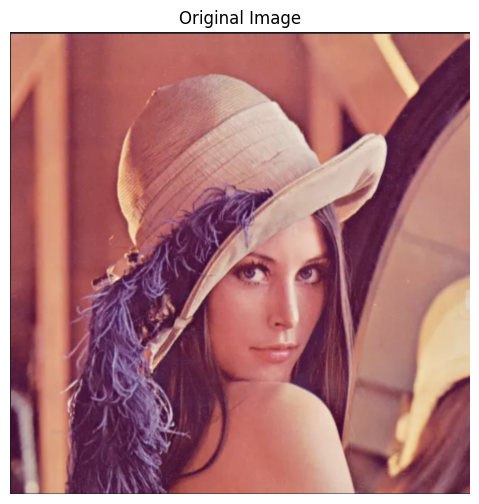

Original dimensions: (1037, 1032, 3)
Resized (Linear): (150, 300, 3)


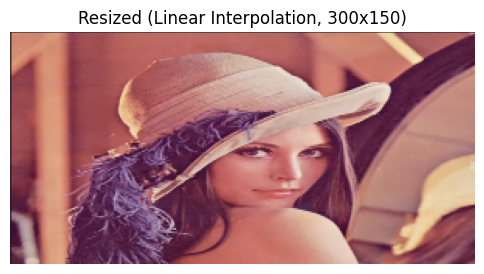

Resized (Nearest): (300, 100, 3)


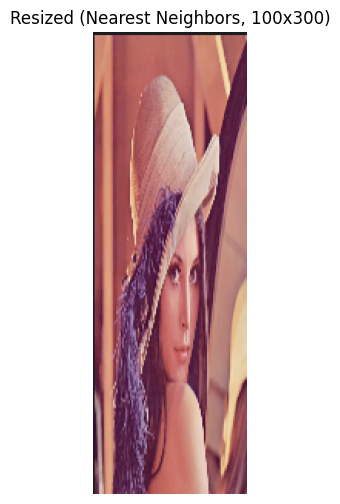

Resized (Cubic): (200, 400, 3)


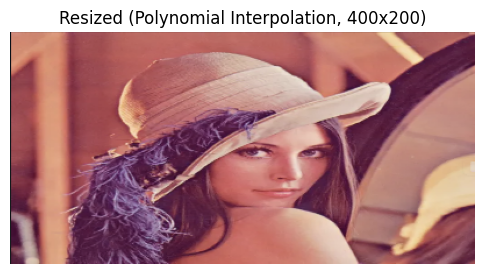

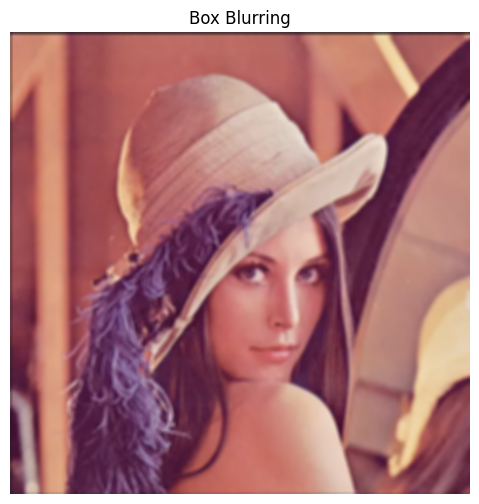

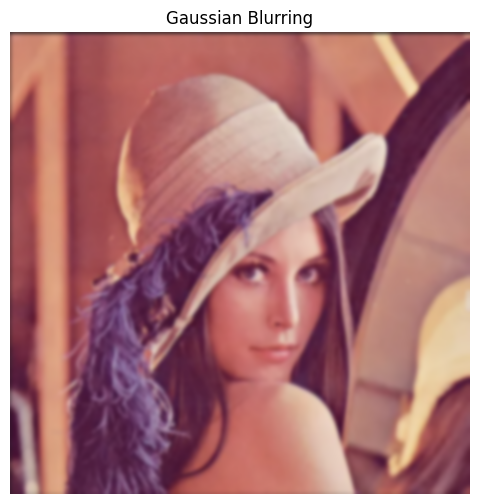

Adaptive kernel size: (21, 21)


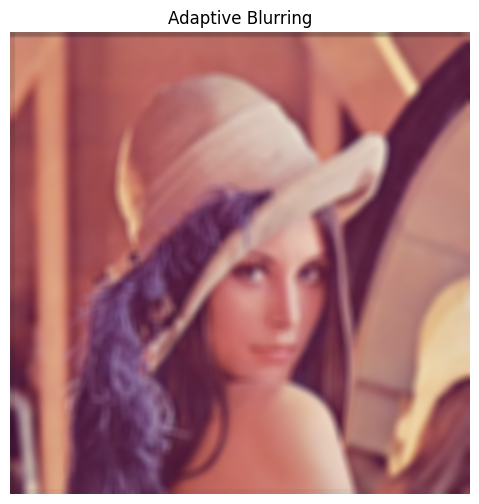

In [23]:
# !pip install opencv-python-headless

import cv2
import numpy as np
import matplotlib.pyplot as plt

def display_image(title, image):
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Load the image
image_path = 'Lenna.png'
image = cv2.imread(image_path)

if image is None:
    print("Error: Image not loaded. Check the file path.")
else:
    display_image("Original Image", image)

    # Debug: Print original dimensions
    print(f"Original dimensions: {image.shape}")

    # 1. Resizing

   # 1.1 Linear Interpolation
    resized_linear = cv2.resize(image, (300, 150), interpolation=cv2.INTER_LINEAR)
    print(f"Resized (Linear): {resized_linear.shape}")
    display_image("Resized (Linear Interpolation, 300x150)", resized_linear)
    
    # 1.2 Nearest Neighbors
    resized_nearest = cv2.resize(image, (100, 300), interpolation=cv2.INTER_NEAREST)
    print(f"Resized (Nearest): {resized_nearest.shape}")
    display_image("Resized (Nearest Neighbors, 100x300)", resized_nearest)
    
    # 1.3 Polynomial Interpolation
    resized_cubic = cv2.resize(image, (400, 200), interpolation=cv2.INTER_CUBIC)
    print(f"Resized (Cubic): {resized_cubic.shape}")
    display_image("Resized (Polynomial Interpolation, 400x200)", resized_cubic)
    # 2. Blurring

    # 2.1 Box Blurring
    blurred_box = cv2.blur(image, (10, 10))
    display_image("Box Blurring", blurred_box)

    # 2.2 Gaussian Blurring
    blurred_gaussian = cv2.GaussianBlur(image, (25, 25), 0)
    display_image("Gaussian Blurring", blurred_gaussian)

    # 2.3 Adaptive Blurring
    # Creating a variable kernel size based on image size
    rows, cols, _ = image.shape
    kernel_size = (cols // 50, rows // 50)
    if kernel_size[0] % 2 == 0:
        kernel_size = (kernel_size[0] + 1, kernel_size[1] + 1)
    print(f"Adaptive kernel size: {kernel_size}")
    blurred_adaptive = cv2.blur(image, kernel_size)
    display_image("Adaptive Blurring", blurred_adaptive)


Evaluating Naive Bayes...
Evaluating Random Forest...
--- Naive Bayes Results ---
Accuracy: 0.8111
Precision: 0.8463
Recall: 0.8103
F1-Score: 0.8137
Confusion Matrix:
[[33  0  0  0  1  1  0  0  1  0]
 [ 0 29  1  0  0  0  1  0  3  2]
 [ 0  3 19  0  0  0  0  0 13  0]
 [ 0  0  1 26  0  0  0  1  8  1]
 [ 0  2  0  0 26  0  1  6  1  0]
 [ 0  0  0  0  0 35  0  1  0  1]
 [ 0  1  0  0  0  0 35  0  0  0]
 [ 0  0  0  0  0  1  0 35  0  0]
 [ 0  4  1  0  0  0  0  1 29  0]
 [ 0  3  1  0  0  0  0  4  3 25]]
Mean AUC: 0.9705


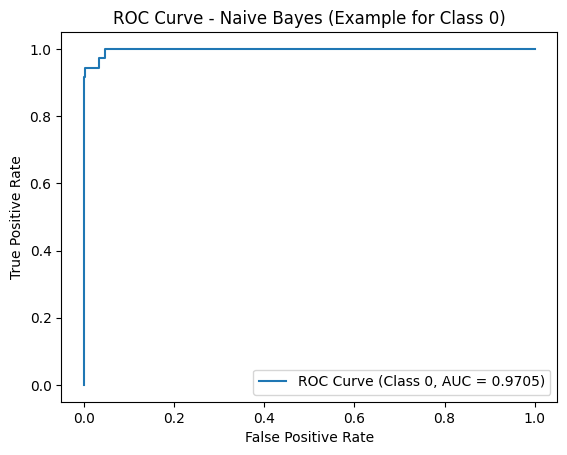

--- Random Forest Results ---
Accuracy: 0.9611
Precision: 0.9620
Recall: 0.9607
F1-Score: 0.9607
Confusion Matrix:
[[35  0  0  0  1  0  0  0  0  0]
 [ 0 35  0  0  0  1  0  0  0  0]
 [ 1  0 34  0  0  0  0  0  0  0]
 [ 0  0  0 36  0  0  0  0  0  1]
 [ 0  1  0  0 35  0  0  0  0  0]
 [ 0  0  0  0  0 37  0  0  0  0]
 [ 0  0  0  0  0  0 35  0  1  0]
 [ 0  0  0  0  0  0  0 36  0  0]
 [ 0  3  0  0  0  0  0  2 30  0]
 [ 0  0  0  1  0  0  0  1  1 33]]
Mean AUC: 0.9992


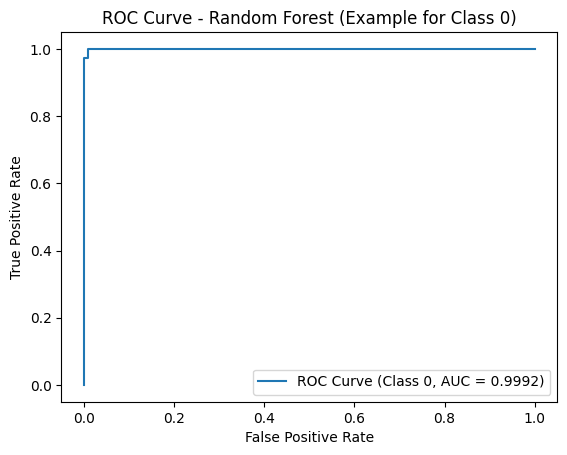

In [45]:
# Importing libraries
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix
)
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Load MNIST dataset
data = load_digits()
X, y = data.data, data.target

# Normalize the pixel values 
X = X / 16.0

# Binarize the labels for ROC and AUC
y_binarized = label_binarize(y, classes=np.unique(y))

# Split into train-test (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
y_test_binarized = label_binarize(y_test, classes=np.unique(y))

# KFold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Helper function to evaluate model
def evaluate_model(model, X_train, y_train, X_test, y_test, y_test_binarized):
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    cm = confusion_matrix(y_test, y_pred)

    # ROC and AUC for multi-class classification (one-vs-all approach)
    y_prob = model.predict_proba(X_test)
    auc_scores = []
    for i in range(y_prob.shape[1]):
        auc = roc_auc_score(y_test_binarized[:, i], y_prob[:, i])
        auc_scores.append(auc)

    # Compute average AUC and plot ROC for the first class (example)
    mean_auc = np.mean(auc_scores)
    fpr, tpr, _ = roc_curve(y_test_binarized[:, 0], y_prob[:, 0])  # Example for class 0
    return accuracy, precision, recall, f1, cm, mean_auc, fpr, tpr

# Naive Bayes (Gaussian)
print("Evaluating Naive Bayes...")
nb_model = GaussianNB()
nb_results = evaluate_model(nb_model, X_train, y_train, X_test, y_test, y_test_binarized)

# Random Forest
print("Evaluating Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_results = evaluate_model(rf_model, X_train, y_train, X_test, y_test, y_test_binarized)

# Display results
def display_results(model_name, results):
    accuracy, precision, recall, f1, cm, mean_auc, fpr, tpr = results
    print(f"--- {model_name} Results ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)
    if mean_auc:
        print(f"Mean AUC: {mean_auc:.4f}")
        plt.figure()
        plt.plot(fpr, tpr, label=f"ROC Curve (Class 0, AUC = {mean_auc:.4f})")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve - {model_name} (Example for Class 0)")
        plt.legend(loc="lower right")
        plt.show()

# Display results for both models
display_results("Naive Bayes", nb_results)
display_results("Random Forest", rf_results)

In [46]:
X

array([[0.    , 0.    , 0.3125, ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.625 , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 1.    , 0.5625, 0.    ],
       ...,
       [0.    , 0.    , 0.0625, ..., 0.375 , 0.    , 0.    ],
       [0.    , 0.    , 0.125 , ..., 0.75  , 0.    , 0.    ],
       [0.    , 0.    , 0.625 , ..., 0.75  , 0.0625, 0.    ]])